In [3]:
import pandas as pd
import os
import pickle

In [ ]:
#Download the initial test statistics
df = pd.read_csv('../Data/permutation_test_files_metabolomics/initial_tstats.csv', index_col=0)
#df = pd.read_csv('../Data/permutation_test_files_proteomics/initial_tstats.csv', index_col=0)


### Reading in the files

Used to test the code I use for the HPC

In [ ]:
os.getcwd()

In [10]:
path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_metabolomics_withoutPA'
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_proteomics'
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_integrated'

Read all the files that start with 'Run' inside a folder:

In [11]:
final_list = []

for filename in os.listdir(path): #also lists directories
    if filename.startswith('Run'):
        file_num = int(filename[3:-4])  #obtain the number of the Run
        if file_num > 11:
            print(filename)
            with open(os.path.join(path, filename), 'rb') as file: # open in readonly mode
                list1 = pickle.load(file)
            final_list.append(list1)

Run98.txt
Run99.txt


Read all the files in a folder that starts with 'Results':

In [ ]:
path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics'
final_list = []

for filename in os.listdir(path): #also lists directories
    if filename.startswith('Results'):
        print(filename)
        #for file in os.listdir(path + '\\' + filename): 
        for file in os.listdir(os.path.join(path,filename)):
            print(file)
            with open(os.path.join(path, filename,file), 'rb') as file: # open in readonly mode
                list1 = pickle.load(file)
            final_list.append(list1)

In a folder with directories list (Results1, Results2, Results3 etc) go through each as a separate array job:


In [ ]:
#index_num = sys.argv[1]  #this should return the array number within the array job
index_num = 1 #for example
path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics\\Results' + str(index_num)
final_list = []

for filename in os.listdir(path): #also lists directories
    print(filename)
    with open(os.path.join(path, filename), 'rb') as file: # open in readonly mode
        list1 = pickle.load(file)
    final_list.append(list1)

In [ ]:
len(final_list)

for list1 in final_list:
    print(len(list1))
    print(list1[:3])

### Calculate which edges are significant

Calculates number of permuted values above the initial test statistic, then divides by number of tests and works out p-value, before outputting the significant edges: (NOT RECOMMENDED, p-values not FDR corrected)

In [ ]:
sig_edges = []
edgelist = df.index

for index,pathway_pair in enumerate(edgelist):   #test all pathways
    comparison = df.Initial_tstat[index]    #get initial test statistic
    counter = 0
    
    for list1 in final_list:  #len(final_list) = number of permutations
        if abs(list1[index]) >= comparison:   
            counter += 1
    
    p_val = (counter/len(final_list))    #divide number of tests above or equal to the test statistic by total number of tests

    if p_val < 0.01:  #for 100,000 permutations
        sig_edges.append(pathway_pair)  
        
print(len(sig_edges))
sig_edges

Calculates number of permuted values above the initial test statistic (more scalable)

In [ ]:
num_vals = []  #number of permuted values above the magnitude of the test statistic
#sig_edges = []
edgelist = df.index

for index in range(len(edgelist)):   #test all pathways
    comparison = df.Initial_tstat[index]    #get initial test statistic
    print(comparison)
    counter = 0
    
    for list1 in final_list:  #len(final_list) = number of permutations
        if abs(list1[index]) >= comparison:   
            counter += 1
    num_vals.append(counter)

num_vals

### Another alternative: (but converting to numpy array actually seems to take up more memory)

In [ ]:
import numpy as np

final_matrix = np.empty((0,len(df)), int)

for filename in os.listdir(path):
    if filename != 'initial_tstats.csv':
        with open(os.path.join(path, filename), 'rb') as file: # open in readonly mode
            list1 = pickle.load(file)
        final_matrix = np.append(final_matrix, np.array([list1]), axis=0)

In [ ]:
final_matrix.shape

In [ ]:
final_matrix = np.array(final_list) 

final_matrix.shape

sig_edges = []
edgelist = df.index

for index,pathway_pair in enumerate(edgelist):   #test all pathways
    comparison = df.Initial_tstat[index]    #get initial test statistic
    counter = 0
    
    col = abs(final_matrix[:,index])  #index a column and turn into absolute values
    counter = (col >= comparison).sum()

    
    p_val = (counter/len(final_list))    #divide number of tests above or equal to the test statistic by total number of tests

    if p_val < 0.01:  #for 100,000 permutations
        sig_edges.append(pathway_pair)  
        
print(len(sig_edges))

In [ ]:
#comparing the size of the object from the first method vs second method ()
from sys import getsizeof
print(getsizeof(final_list))
print(getsizeof(final_matrix))

Saving the file:

In [ ]:
#Writing as text file
with open ('Data/permutation_test_files_metabolomics/vals_test.txt', 'w') as file:
     file.write(','.join(str(i) for i in num_vals))

In [ ]:
#Pickling the file to save on memory space
with open('Data/permutation_test_files_metabolomics/vals_test.txt', "wb") as file:  
       pickle.dump(output,file)

### Read in HPC results (reading ten files):

In [1]:
import os 
import numpy as np 
import statsmodels.stats.multitest
import pandas as pd
from itertools import compress

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Read ten files that have the number of edges that are of a higher value that the initial test statistic

#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_metabolomics\\Values'   #[:-13] because we want to move back a directory
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_proteomics\\Values'
path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_integrated\\Values'

#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_metabolomics_withoutPA\\Values'
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_proteomics_withoutPA\\Values'
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_integrated_withoutPA\\Values'

val_array = []


for filename in os.listdir(path): #also lists directories
    with open(os.path.join(path, filename)) as file:    
        lines = file.readlines()
        vals = lines[0].split(';')
        vals =  [int(x) for x in vals]
        #print(vals)
        if filename == 'vals1.txt':
            val_array = np.array(vals)
        else:
            val_array = np.vstack([val_array, vals])

In [3]:
val_array
val_array2 = val_array.sum(axis=0) #add up the values by columns for each pathway pair
pval_array = val_array2 / 100000
pval_array[:20]
print(len(pval_array)) #10,296 for metabolomic, 166,753 values for proteomic, 251,695 values for integrated
(pval_array < 0.05).sum() #763 for metabolomic,  58,115 values for proteomic, 68,299 values for integrated


#Before I realised I forgot to scale: 795 values for metabolomic, 56,256 values for proteomic, 65,208 values for integrated

IndexError: invalid index to scalar variable.

In [56]:
#Molecular-level differential network ONLY 
pval_array = val_array / 10000
print(len(pval_array)) #55,278 for metabolomic_withoutPA, 102,831 values for proteomic_withoutPA, 309,291 values for integrated
(pval_array < 0.05).sum() #8995 for metabolomic_withoutPA, 25,958 values for proteomic_withoutPA, 58,882 values for integrated


309291


58882

Text(0, 0.5, 'Count')

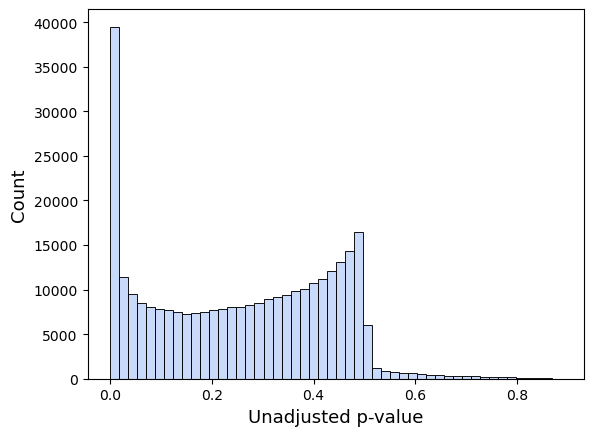

In [57]:
sns.histplot(pval_array, bins = 50,color='#B8CDF8',edgecolor="k") 

#plt.title('Metabolomic unadjusted p-value distribution',fontsize=16)
#plt.title('Proteomic unadjusted p-value distribution',fontsize=16)
#plt.title('Integrated unadjusted p-value distribution',fontsize=16)

plt.xlabel('Unadjusted p-value',fontsize=13)
plt.ylabel('Count',fontsize=13) 



#plt.savefig( 'Figures/unadjusted_pval_proteomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig( 'Figures/unadjusted_pval_integrated.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [58]:
sig_edge_boolean,adjusted_pval = statsmodels.stats.multitest.fdrcorrection(pval_array, alpha=0.005, method='poscorr', is_sorted=False)
#sig_edge_boolean,adjusted_pval = statsmodels.stats.multitest.fdrcorrection(pval_array, alpha=0, method='poscorr', is_sorted=False)
sig_edge_boolean

array([False, False, False, ..., False, False, False])

In [59]:
sig_edge_boolean2,adjusted_pval2 = statsmodels.stats.multitest.fdrcorrection(pval_array, alpha=0.005, method='indep', is_sorted=False)
sig_edge_boolean2

array([False, False, False, ..., False, False, False])

In [60]:
print(adjusted_pval)
print(adjusted_pval2)

[0.51849089 0.51849089 0.02736234 ... 0.51849089 0.04874765 0.04593366]
[0.51849089 0.51849089 0.02736234 ... 0.51849089 0.04874765 0.04593366]


In [61]:
sig_edge_boolean == sig_edge_boolean2
np.array_equiv(sig_edge_boolean,sig_edge_boolean2)

True

In [62]:
adjusted_pval

array([0.51849089, 0.51849089, 0.02736234, ..., 0.51849089, 0.04874765,
       0.04593366])

In [63]:
#(adjusted_pval < 0.005).sum()
(adjusted_pval == 0).sum()   
#metabolomic = 17 edges have a p-value of 0  
#proteomic = 1592 edges have a p-value of 0         
#integrated = 2432 edges have a p-value of 0

8157

In [42]:
significance_ordered = list(adjusted_pval[adjusted_pval < 0.005])
significance_ordered.sort()
#significance_ordered

In [64]:
sum(sig_edge_boolean) 

#One-sided permutation testing:
#Metabolomic - 214 edges at p < 0.05 and 53 edges at  p < 0.005
#Proteomic - 15,730 edges at p < 0.05 and 8,753 edges at p < 0.005
#Integrated - 45,123 edges at p < 0.05 and 9,069 edges at p < 0.005

#Two sided permutation testing (before I realised that I forgot to scale the two dataset after subsetting)
#Metabolomic - 8 edges significant with method=indep and method=poscorr
#Metabolomic without PA - 70 edges significant with method=indep and method=poscorr
#Proteomic - 31,486 edges significant with method=indep and method=poscorr
#Integrated - 26,761 edges significant with method=indep and method=poscorr (less than proteomic because more edges so penalised more heavily)

#Analyte-level:
#Metabolomic - 1,660 edges at p < 0.005 and 1,347 edges at  p == 0
#Proteomic - 5,109 edges at p < 0.005 and 3,572 edges at p == 0 
#Integrated - 10,221 edges at p < 0.005 and 8,157 edges at p == 0


10221

Text(0, 0.5, 'Count')

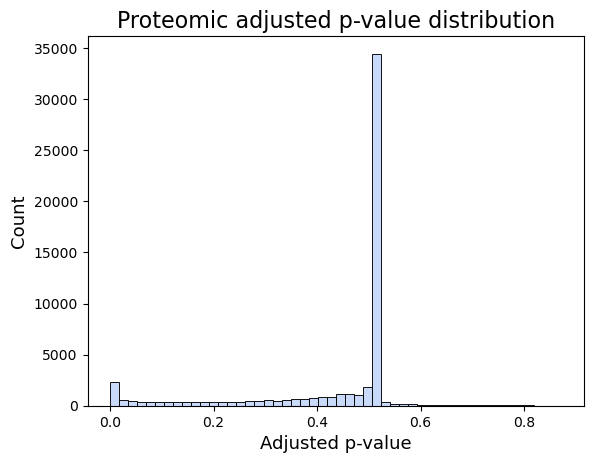

In [44]:
sns.histplot(adjusted_pval, bins = 50,color='#B8CDF8',edgecolor="k") 

#plt.title('Metabolomic adjusted p-value distribution',fontsize=16)
#plt.title('Metabolomic without PA adjusted p-value distribution',fontsize=16)
plt.title('Proteomic adjusted p-value distribution',fontsize=16)
#plt.title('Integrated adjusted p-value distribution',fontsize=16)

plt.xlabel('Adjusted p-value',fontsize=13)
plt.ylabel('Count',fontsize=13) 

#plt.savefig( 'Figures/adjusted_pval_metabolomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig( 'Figures/adjusted_pval_metabolomic_withoutPA.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig( 'Figures/adjusted_pval_proteomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig( 'Figures/adjusted_pval_integrated.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')



Easier to obtain the reverse (i.e. edges that are not significant), since then they can be removed easily

In [51]:
not_sig_edge_boolean = [not elem for elem in sig_edge_boolean]
sum(not_sig_edge_boolean )

249263

In [5]:
#Load dataset
#df = pd.read_csv('../Data/permutation_test_files_metabolomics/initial_tstats.csv', index_col=0)
#df = pd.read_csv('../Data/permutation_test_files_proteomics/initial_tstats.csv', index_col=0)
df = pd.read_csv('../Data/permutation_test_files_integrated/initial_tstats.csv', index_col=0)
edgelist = df.index


sig_edges = list(compress(edgelist,sig_edge_boolean))
not_sig_edges = list(compress(edgelist,not_sig_edge_boolean))

#Zip p-values to edge names to form dictionary (so I can test significance of differentially expressed genes)
edgelist_tuple = []
for i in range(len(edgelist)):
    edge = edgelist[i].split(",")
    edge = (edge[0],edge[1][1:])
    edgelist_tuple.append(edge)
    
p_val_dict  = dict(zip(edgelist_tuple, adjusted_pval))

NameError: name 'sig_edge_boolean' is not defined

In [4]:
edgelist

NameError: name 'edgelist' is not defined

In [53]:
sig_df = df.loc[sig_edges]

sigedge_direction = []

for i in range(len(sig_df)):
    if sig_df.Initial_tstat[i] > 0:
        sigedge_direction.append("mild")
    if sig_df.Initial_tstat[i] < 0:
        sigedge_direction.append("severe")

In [54]:
print(sigedge_direction.count("mild"))
print(sigedge_direction.count("severe"))

113
2319


Saving the significant edges: Easier to compare with the naive networks and the other omics networks as well <br>
Saving the non-significant edges: Easier when constructing the differential network analysis

In [43]:
#with open ('../Data/permutation_test_files_metabolomics/sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))
     
#with open ('../Data/permutation_test_files_metabolomics/not_sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in not_sig_edges))

#with open ('../Data/permutation_test_files_metabolomics/sigedge_direction.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sigedge_direction))

#----------------------------------------------------


#All edges with a p-value of zero:
#with open ('../Data/permutation_test_files_metabolomics/pval0_sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))

#with open ('../Data/permutation_test_files_metabolomics/pval0_sigedge_direction.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sigedge_direction))

In [ ]:
#Save number of significant edges BEFORE FDR CORRECTION

#sig_edges_beforefdr = list(compress(edgelist,pval_array < 0.05))
#print(len(sig_edges_beforefdr))

#with open ('Data/permutation_test_files_metabolomics/sig_edges_beforefdr.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges_beforefdr))

In [ ]:
#with open ('Data/permutation_test_files_metabolomics_withoutPA/sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))
     
#with open ('Data/permutation_test_files_metabolomics_withoutPA/not_sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in not_sig_edges))

In [28]:
#with open ('../Data/permutation_test_files_proteomics/sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))
     
#with open ('../Data/permutation_test_files_proteomics/not_sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in not_sig_edges))

#with open ('../Data/permutation_test_files_proteomics/sigedge_direction.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sigedge_direction))
 
#----------------------------------------------------

#All edges with a p-value of zero:
#with open ('../Data/permutation_test_files_proteomics/pval0_sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))

#with open ('../Data/permutation_test_files_proteomics/pval0_sigedge_direction.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sigedge_direction))

In [55]:
#with open ('../Data/permutation_test_files_integrated/sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))
     
#with open ('../Data/permutation_test_files_integrated/not_sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in not_sig_edges))

#with open ('../Data/permutation_test_files_integrated/sigedge_direction.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sigedge_direction))

#----------------------------------------------------

#All edges with a p-value of zero:
#with open ('../Data/permutation_test_files_integrated/pval0_sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))

#with open ('../Data/permutation_test_files_integrated/pval0_sigedge_direction.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sigedge_direction))

### Plotting the test statistic distribution for randomly chosen pathway pairs


In [ ]:
import pandas as pd
import os
import random
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Download the initial test statistics
#df = pd.read_csv('Data/permutation_test_files_metabolomics/initial_tstats.csv', index_col=0)
#df = pd.read_csv('Data/permutation_test_files_proteomics/initial_tstats.csv', index_col=0)
df = pd.read_csv('Data/permutation_test_files_integrated/initial_tstats.csv', index_col=0)


#path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics'
#path = os.getcwd() + '\\Data\\permutation_test_files_proteomics'
path = os.getcwd() + '\\Data\\permutation_test_files_integrated'

In [ ]:
df

Selecting random pathways and writing to a file without the HPC:

In [ ]:


#pathway_list = []

#for i in range(8): #take 8 random pathways
#    index = random.randrange(0, len(df)) #Gives index from 0 to (len(df)-1), better for indexing with unpickled files which are stored as lists
#    print(index)
#    for filename in os.listdir(path):
#            if filename.startswith('Run'):
#                with open(os.path.join(path, filename),'rb') as file:
#                    list1 = pickle.load(file)   
#                    #print(len(list1))
#                    pathway_list.append(list1[index])
#    with open('Data/permutation_test_files_metabolomics/test_distribution'+str(index)+'.txt', 'w') as file:
#        file.write(','.join(str(i) for i in pathway_list))
#    print(len(pathway_list))
#    pathway_list = []




Read in the test distribution files that were made from the HPC and plotting:

In [ ]:
val_array = []


#Run all the test distribution files:
#for filename in os.listdir(path): #also lists directories
#    if filename.startswith('test'):
#        with open(os.path.join(path, filename)) as file:    
#            lines = file.readlines()
#            vals = lines[0].split(',')
#            vals =  [float(x) for x in vals]
#            print(len(vals))
#            print(vals[:100])
            

#I've plotted figures for the following (metabolomics): 855, 1496 (sig before correction), 1884, 1897, 2391, 2681 (sig before correction, not normal), 2747, 3660, 4665, 4692, 5958, 7664 (normal), 8257, 9949, 10215
#I've plotted figures for the following (proteomics): 492 (sig - no permutations over), 1863 (weird bimodal distribution, 3212 (sig before correction), 3379, 11886 (sig before correction), 15302 (sig before correction), 19587 (sig before correction, weird distribution), 44413 (sig), 80764, 98000(sig), 142402, 143312, 145571 (sig, weird distribution), 153715 (sig - no permutations over), 157122 (not sig, normal)
#I've plotted figures for the following (integrated): 19156, 29535, 39570, 67801 (sig before correction), 82140, 96565, 96908 (sig before correction, normal), 101041, 124135, 184762 (sig), 236500 (sig before correction)

#Open the test distribution files one by one:
test_num = 239468
#with open('Data/permutation_test_files_metabolomics/Test_distribution/test_distribution'+str(test_num)+'.txt') as file:
#with open('Data/permutation_test_files_proteomics/Test_distribution/test_distribution'+str(test_num)+'.txt') as file:
with open('Data/permutation_test_files_integrated/Test_distribution/test_distribution'+str(test_num)+'.txt') as file:
    comparison = df.Initial_tstat[test_num]
    edge_name = df.index[test_num]

    lines = file.readlines()
    vals = lines[0].split(',')
    vals =  [float(x) for x in vals]
    print(len(vals))
    print(vals[:100])


#For metabolomics:
#sns.histplot(vals, bins = 50,color='#59C3C3',edgecolor="k") 

#For proteomics:
#sns.histplot(vals, bins = 50,color='#4062BB',edgecolor="k") 

#For integrated data:
sns.histplot(vals, bins = 50,color='#52489C',edgecolor="k") 


plt.title('Pathway pair '+ edge_name,fontsize=16)
plt.xlabel('Delta value',fontsize=13)
plt.ylabel('Count',fontsize=13) 

plt.axvline(x=comparison, color='r', linewidth=0.5, linestyle='--', dashes=(8, 5))
plt.axvline(x=-comparison, color='r', linewidth=0.5, linestyle='--', dashes=(8, 5))

#Count number of values (made absolute) that are over the initial test statistic (made absolute) for two sided permutation test
counter = 0 
for index in range(len(vals)):  #len(final_list) = number of permutations
    if abs(vals[index]) >= comparison:   
        counter += 1
print(counter)


#MUST RUN THE ABOVE CODE TO LOAD IN THE NUMBER OF VALUES THAT ARE ABOVE THE INITIAL TEST STATISTIC SO I KNOW WHETHER THE PATHWAY PAIR IS SIGNIFICANT AFTER FDR CORRECTION
if sig_edge_boolean[test_num] == True:
    plt.text(-0.8, -2600, "Adjusted p-value significant",fontsize=10)
else:
    plt.text(-0.8, -2600, "Not significant",fontsize=10)
plt.text(-0.8, -3200, "Unadjusted p-value: " + str(pval_array[test_num]),fontsize=10)
plt.text(-0.8, -3800, "FDR-adjusted p-value: " + str(adjusted_pval[test_num]),fontsize=10)
plt.text(-0.8, -4400, "Number of values above initial test statistic: " + str(counter),fontsize=10)



plt.xlim(-0.9,0.9)   #-log_10(0.005) = 2.301...
plt.ylim(0,15000) 

#plt.savefig( 'Figures/Pathway ' + edge_name + '.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')